# Moving Average Crossover trading strategy with backtest


variables that can be changed for testing purposes:
- `ticker`
- `ema_fast` and `ema_slow` exponencial moving averages
- `profit_target` 

Script is getting daily stock data from Yahoo! Finance API. Exponencial moving average crossover strategy is implemented - both for long and short entries. Long entry is also having profit target option if `profit_target` variable is set to be greater than 1.0. Profit target is implemented at market open. Regular buy and sell positions based on signal are done at market close for backtesting purposes.

So let's say, crossover signals buy on Monday, the actual buy is executed at Market close price on Tuesday (to prevent backtesting bias).


In [233]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import datetime
import time

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

# was giving me some warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Variable definitions

In [234]:
start_time = datetime.datetime(2018, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

ticker = 'AAPL'

### Function definitions

In [235]:
def get_data(ticker):
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

## getting crypto data for multiple timeframes
every timeframe will its own dataframe (crypto API provides various timeframe aggregation for free)

In [236]:
# to be done if needed

### other function definitions

In [237]:
def compute_technical_indicators(df):
    
    df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)   
    df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=20)
    df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)    
    
    df['EMA50'] = ta.EMA(df['Adj Close'].values, timeperiod=50)   
    df['EMA100'] = ta.EMA(df['Adj Close'].values, timeperiod=100)
    df['EMA150'] = ta.EMA(df['Adj Close'].values, timeperiod=150)
    df['EMA200'] = ta.EMA(df['Adj Close'].values, timeperiod=200) 

    df.tail()

    return df

In [238]:
def plot_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title('Stock data ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [239]:
df = get_data(ticker)

connected to yahoo


In [240]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.105534
1,2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.098373
2,2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.289268
3,2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,41.759361
4,2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.604263


In [241]:
df = compute_technical_indicators(df)

In [242]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,EMA10,EMA20,EMA30,EMA40,EMA50,EMA100,EMA150,EMA200
0,2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.105534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.098373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.289268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,41.759361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.604263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


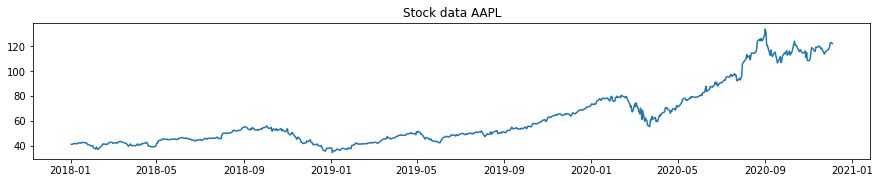

In [243]:
plot_data(df)

In [244]:
def crossover_signal(df, ema_fast, ema_slow):
    # ema variable is string e.g. 'EMA50'
    # it is chosen column name from df
    
    # adds two columns to dataframe with buy and sell signals
    buy_list = []
    sell_list = []
    action_list = []
    
    #i buy day after I evaluate closing prices
    # so buying day after 
    
    for i in range(2,len(df['Adj Close'])):
        if (df[ema_fast][i-1] > df[ema_slow][i-1]) and (df[ema_fast][i-2] < df[ema_slow][i-2]):         # buy signal      
            
            print('BUY', df['Adj Close'][i])
            
            buy_list.append(df['Adj Close'][i])
            sell_list.append(np.nan)
            action_list.append(1)
        elif (df[ema_fast][i-1] < df[ema_slow][i-1]) and (df[ema_fast][i-2] > df[ema_slow][i-2]):       # sell signal     
            
            print('SELL',df['Adj Close'][i])
            
            buy_list.append(np.nan)
            sell_list.append(df['Adj Close'][i]) 
            action_list.append(-1)
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            action_list.append(0)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell') 
    action_list = pd.Series(action_list, name='Action')
        
    df = df.join(buy_list)
    df = df.join(sell_list) 
    df = df.join(action_list)
        
        
    print(buy_list)    
        
        
    return df

In [245]:
def plot_signals(df, ticker, ema_fast, ema_slow):
    # plot price
    plt.figure(figsize=(30,10))
    plt.plot(df['Date'], df['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(30,10))
    plt.title('EMA trading strategy chart ' + str(ticker) + str(ticker) )
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close')

    plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    plt.plot(df['Date'], df[ema_fast], label=str(ema_fast), alpha=0.3)
    plt.plot(df['Date'], df[ema_slow], label=str(ema_slow), alpha=0.3)

    # scatter plot cannot convert dates correctly
    #plt.scatter(df['Date'], df['Buy'], label='Buy', marker='^')
    #plt.scatter(df['Date'], df['Sell'], label='Sell', marker='v')
    
    #temp workaround for scatter plots
    #df = df.fillna(0)
    plt.plot(df['Date'], df['Buy'], label='Buy', linestyle='None', marker='^', markersize=10, color='green')
    plt.plot(df['Date'], df['Sell'], label='Sell', linestyle='None', marker='v', markersize=10, color='red')    

    plt.legend()

    plt.show()

#### Graph with trading signals

In [246]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,EMA10,EMA20,EMA30,EMA40,EMA50,EMA100,EMA150,EMA200
0,2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.105534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.098373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.289268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,41.759361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.604263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
ema_fast = 'EMA20'
ema_slow = 'EMA50'
#ema = 'EMA200'
df = crossover_signal(df, ema_fast, ema_slow)
df.tail()

SELL 40.74361801147461
BUY 41.72356414794922
SELL 39.21017837524414
BUY 44.36393737792969
SELL 49.183006286621094
BUY 42.380794525146484
SELL 43.52073287963867
BUY 48.31648254394531
SELL 70.31636810302734
BUY 71.23554229736328
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
731   NaN
732   NaN
733   NaN
734   NaN
735   NaN
Name: Buy, Length: 736, dtype: float64


,Date,High,Low,Open,Close,Volume,Adj Close,EMA10,EMA20,EMA30,EMA40,EMA50,EMA100,EMA150,EMA200,Buy,Sell,Action
733,2020-11-30,120.970001,116.809998,116.970001,119.050003,169410200.0,119.050003,117.114626,116.867407,116.565523,116.141949,115.510198,110.135591,104.022778,98.520483,NaN,NaN,0.0
734,2020-12-01,123.470001,120.010002,121.010002,122.720001,128166800.0,122.720001,118.133785,117.424797,116.962586,116.462830,115.792936,110.384787,104.270423,98.761274,NaN,NaN,0.0
735,2020-12-02,123.370003,120.889999,122.019997,123.080002,89004200.0,123.080002,119.033097,117.963388,117.357258,116.785619,116.078703,110.636178,104.519557,99.003252,NaN,NaN,0.0
736,2020-12-03,123.779999,122.209999,123.519997,122.940002,78967600.0,122.940002,119.743444,118.437351,117.717435,117.085833,116.347774,110.879818,104.763536,99.241428,NaN,NaN,NaN
737,2020-12-04,122.860001,121.519997,122.599998,122.250000,78133200.0,122.250000,120.199181,118.800461,118.009859,117.337743,116.579234,111.104970,104.995145,99.470369,NaN,NaN,NaN


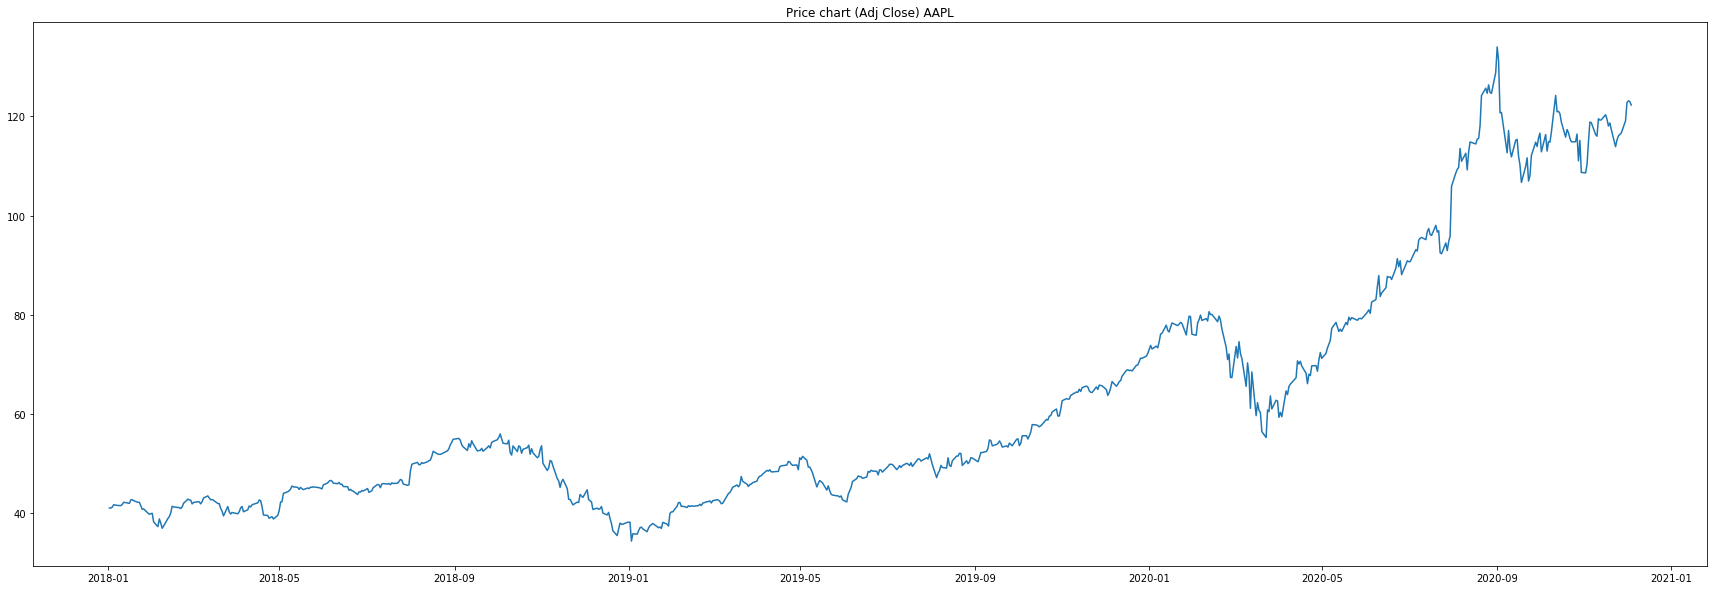

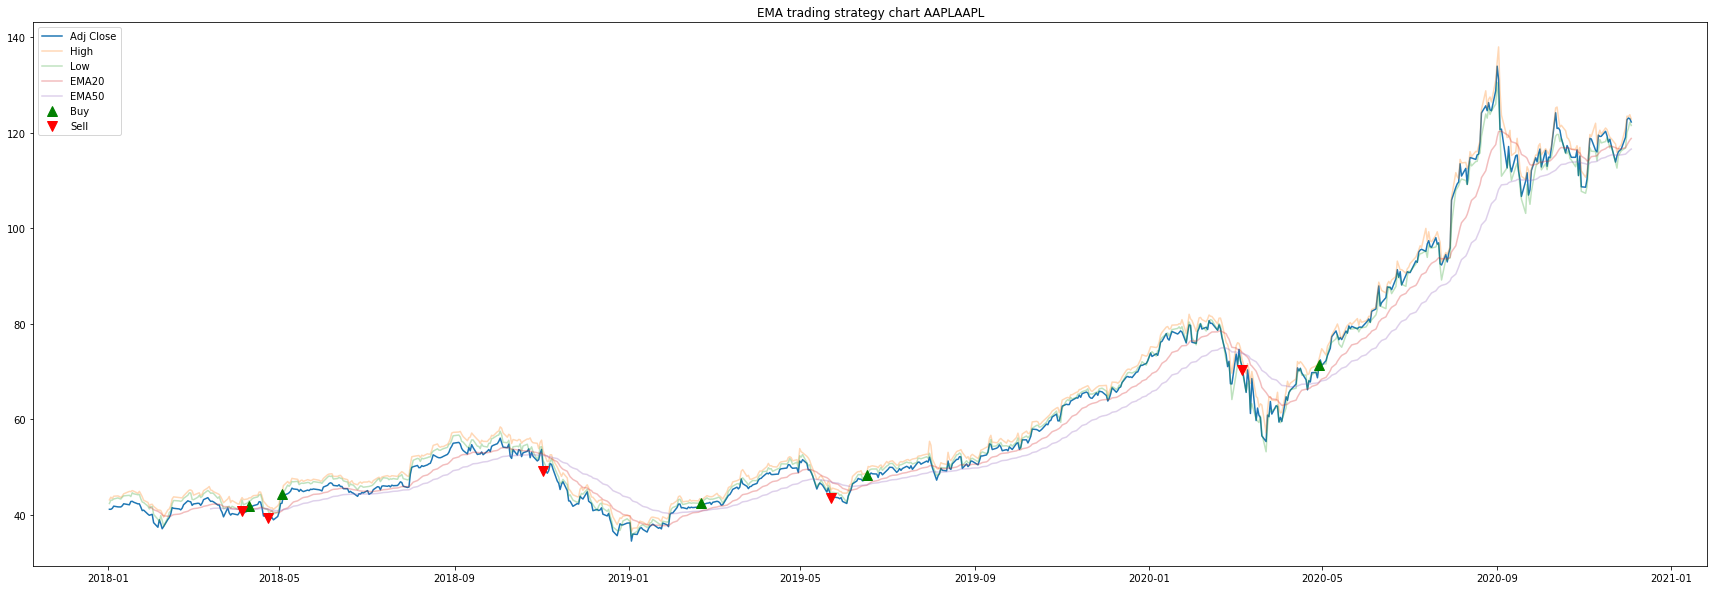

In [248]:
plot_signals(df, ticker, ema_fast, ema_slow)

In [249]:
def ema_diff(df):
    
    df['EMA10_diff'] = (df['Adj Close'] / df['EMA10']) - 1
    df['EMA20_diff'] = (df['Adj Close'] / df['EMA20']) - 1
    df['EMA30_diff'] = (df['Adj Close'] / df['EMA30']) - 1
    df['EMA40_diff'] = (df['Adj Close'] / df['EMA40']) - 1     
    
    
    df['EMA50_diff'] = (df['Adj Close'] / df['EMA50']) - 1
    df['EMA100_diff'] = (df['Adj Close'] / df['EMA100']) - 1
    df['EMA150_diff'] = (df['Adj Close'] / df['EMA150']) - 1
    df['EMA200_diff'] = (df['Adj Close'] / df['EMA200']) - 1
    
    # squeeze
    df['EMA10_squeeze'] = (df['EMA10'] / df['EMA200']) - 1
    df['EMA20_squeeze'] = (df['EMA20'] / df['EMA200']) - 1
    df['EMA30_squeeze'] = (df['EMA30'] / df['EMA200']) - 1
    df['EMA40_squeeze'] = (df['EMA40'] / df['EMA200']) - 1       
    
    df['EMA50_squeeze'] = (df['EMA50'] / df['EMA200']) - 1
    df['EMA100_squeeze'] = (df['EMA100'] / df['EMA200']) - 1
    df['EMA150_squeeze'] = (df['EMA150'] / df['EMA200']) - 1
    df['EMA200_squeeze'] = (df['EMA200'] / df['EMA200']) - 1        
    

    return df

In [250]:
df = ema_diff(df) 


### Simple backtests

In [251]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,EMA10,EMA20,EMA30,...,EMA150_diff,EMA200_diff,EMA10_squeeze,EMA20_squeeze,EMA30_squeeze,EMA40_squeeze,EMA50_squeeze,EMA100_squeeze,EMA150_squeeze,EMA200_squeeze
0,2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.105534,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.098373,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.289268,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,41.759361,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.604263,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Long backtest

In [252]:
profit_target = 1.40   # 15% gain, 0 means turned off



holding = 0
balance_list = []
partial_balance = 0
total_balance = 0

buy_spread=1.01
sell_spread=0.99

In [253]:
# Counts only closed position pairs
# buy and sell of given position has been performed
# at the end can still have one open position, that is waiting to be sold

for i in range(len(df)):
    #print(i)
    
    # buying if not holding yet                                 # long, BUY to OPEN
    if ( holding==0 and df['Action'][i]==1 ):
        buy_price = df['Adj Close'][i] * buy_spread
        #buy_price = df['Open'][i] * buy_spread
        print('buy_price:',buy_price)
        holding=1
        
    # profit target checking if specified for long entries  
    # will sell at the market open once target reached, so I dont wait to another day
    elif (holding==1 and profit_target > 1.0 and df['Open'][i]/buy_price >= profit_target):
        sell_price = df['Open'][i] * sell_spread    
        print('sell_price:',sell_price)
        holding=0    
        partial_balance= sell_price - buy_price
        balance_list.append(partial_balance)
        
    # selling when already holding                              # long, SELL to CLOSE
    elif ( holding==1 and df['Action'][i]==-1 ):    
        sell_price = df['Adj Close'][i] * sell_spread
        #sell_price = df['Open'][i] * sell_spread
        print('sell_price:',sell_price)
        holding=0
        partial_balance= sell_price - buy_price
        balance_list.append(partial_balance)
        
    else:
        pass
 

# if im still holding position, add unrealized profit/loss to the total balance
# with last known Adj Close price
if holding==1:
    partial_balance= df['Adj Close'].iloc[-1] - buy_price    
    balance_list.append(partial_balance)



buy_price: 41.92542964935303
sell_price: 39.1952331161499
buy_price: 42.80628616333008
sell_price: 49.57769119262695
buy_price: 42.025796241760254
sell_price: 43.431215858459474
buy_price: 47.81808906555176
sell_price: 66.30524848937988
buy_price: 71.61438781738282
sell_price: 101.85615211486817


#### profit from long strategy with profit targets set:

In [254]:
total_balance = sum(balance_list)    
print(total_balance) 

54.17555183410643


In [255]:
print('am i still holding some position?:', holding)

am i still holding some position?: 0


In [256]:
df['Adj Close'].tail()

733    119.050003
734    122.720001
735    123.080002
736    122.940002
737    122.250000
Name: Adj Close, dtype: float64

#### Short backtest

In [257]:
# not counting overnight short fees
# instead of it we can simulate it with larger spread for example

holding = 0
balance_list = []
partial_balance = 0
total_balance = 0

# reset price values to be sure
buy_price = 0
sell_price = 0

buy_spread=1.01
sell_spread=0.99

In [258]:
# Counts only closed position pairs
# buy and sell of given position has been performed
# at the end can still have one open position, that is waiting to be sold

for i in range(len(df)):
    #print(i)
    # buying if not holding yet
    if ( holding==1 and df['Action'][i]==1 ):                # shorting, BUY to CLOSE
        buy_price = df['Adj Close'][i] * buy_spread
        #buy_price = df['Open'][i] * buy_spread
        print('buy_price:',buy_price)
        holding=0
        
        # closing position and computing partial profit
        partial_balance= sell_price - buy_price
        balance_list.append(partial_balance)        
        
    # selling when already holding    
    elif ( holding==0 and df['Action'][i]==-1 ):             # shorting, SELL to OPEN
        sell_price = df['Adj Close'][i] * sell_spread
        #sell_price = df['Open'][i] * sell_spread
        print('sell_price:',sell_price)
        holding=1
    else:
        pass
 

# if im still holding SHORT position, add unrealized profit/loss to the total balance
# with last known Adj Close price
if holding==1:
    partial_balance= df['Adj Close'].iloc[-1] - buy_price    
    balance_list.append(partial_balance)



sell_price: 40.988478927612306
buy_price: 41.92542964935303
sell_price: 39.1952331161499
buy_price: 42.80628616333008
sell_price: 49.57769119262695
buy_price: 42.025796241760254
sell_price: 43.431215858459474
buy_price: 47.81808906555176
sell_price: 70.51342826843262
buy_price: 71.61438781738282


#### profit from shorting:

In [259]:
total_balance = sum(balance_list)    
print(total_balance) 

-2.48394157409669


In [260]:
print('am i still holding some position?:', holding)

am i still holding some position?: 0


In [261]:
df['Adj Close'].tail()

733    119.050003
734    122.720001
735    123.080002
736    122.940002
737    122.250000
Name: Adj Close, dtype: float64